# Evaluation for CiviComments
This is the notebook accompanying the Evaluation section of CiviComments where the ranker CiviRank is evaluated based on the Comment Data from the "DerStandard" comment sections from May 2019, kindly provided by Emma Fraxanet, see [here](https://academic.oup.com/pnasnexus/article/3/12/pgae276/7713083?login=false).

In [45]:
%load_ext autoreload
%autoreload 2
%pip install ipywidgets --upgrade
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension install --py widgetsnbextension --sys-prefix
from evaluation import EvaluationDataGenerator, EvaluationCollector
import pandas as pd
from civirank import CiviRank
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
from pandas.plotting import parallel_coordinates
import os
from dotenv import load_dotenv
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


## Set Constants for Evaluation

In this section, we define the constants that determine the number of items to be evaluated in the analysis. This helps in maintaining consistency and reproducibility in our experiments.

- `ARTICLES_TO_EVALUATE`: The number of articles to be sampled and evaluated. Currently set to 10.
- `ARTICLES_TO_OVERVIEW`: The number of articles considered in overview diagrams.
- `CIVIRANK_SCROLL_WARNING_LIMIT`: = 0.` The threshold below wich CiviRank puts a scroll warning.

In [50]:
ARTICLES_TO_OVERVIEW = 5
CIVIRANK_SCROLL_WARNING_LIMIT = -0.16 #similar to default setting
EVAL_BIN_SIZE = 100
PRINT_PLOTS = True
FIGURE_PATH = "figures/"
TEMP_PATH = "temp/"
utils.FIGURE_PATH = FIGURE_PATH
rc = {
  "scatter.edgecolors": "none",
    # "font.size": 16,
    # "axes.titlesize": 18,
    # "axes.labelsize": 16,
    # "xtick.labelsize": 14,
    # "ytick.labelsize": 14,
    # "legend.fontsize": 14,
    }
#sns.set_context('paper', rc=rc) if PRINT_PLOTS else sns.set_context('notebook', rc=rc)
sns.set_theme('paper' if PRINT_PLOTS else 'notebook', 'white', rc=rc)
#custom_palette = sns.color_palette("Set2", 8)
custom_palette = ['#16A29F', '#b91c1c', '#e67015', '#e4ce57', '#7ca287', '#301128']
sns.set_palette(custom_palette)
color_list = [custom_palette[0], 'white', custom_palette[1]]
custom_heatmap_cmap = LinearSegmentedColormap.from_list(
    "custom_primary_secondary", color_list, N=256
)


## Data Import and Ranker Init
Here the Helper Class for Generating Data is initialized, it reads the data from the raw files and later provides util functions. Additionally the CiviRank ranker object is started.

In [3]:
load_dotenv()

path_to_data = "data/may_2019"
eval_gen = EvaluationDataGenerator(path_to_data)
ranker = CiviRank(language="ger")

Language set to ger
ToxicityAnalyzer set to celadon


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Prosociality and Polarization Analyzers initialized
Civirank initialized!


### Comment Metadata
This imports the metadata for all comments on all articles in the Dataset, which includes all of May 2019.

In [4]:
metadata = eval_gen.get_comments_metadata()
print(f"Total amount of comments in Dataset: {len(metadata)}")

Total amount of comments in Dataset: 737903


## General Overview
First, the summed comments are analyzed in the context of the articles.
Most importantly, the median of comments on a article is calculated, as these are used in the thesis as examplary for "standard" cases of comment sections.
Other than that, the relation between total comments, total votes, up- and downvotes is explored and visualized

In [ ]:
# Aggregate the sum of Votes_Pos and Votes_Neg for each Article_Id
aggregated = metadata.groupby('Article_Id').agg(
    counts=('Article_Id', 'size'),
    Votes_Pos_Sum=('Votes_Pos', 'sum'),
    Votes_Neg_Sum=('Votes_Neg', 'sum')
).reset_index()
print(f"Total amount of articles in Dataset: {len(aggregated)}")
aggregated["Votes_Total"] = aggregated["Votes_Neg_Sum"] + aggregated["Votes_Pos_Sum"]
aggregated["VotesToComments"] = aggregated["Votes_Total"] / aggregated["counts"]
aggregated["NegVotesToComments"] = aggregated["Votes_Neg_Sum"] / aggregated["counts"]
aggregated["PosffVotesToComments"] = aggregated["Votes_Pos_Sum"] / aggregated["counts"]
aggregated["NegVotesPercentage"] = (aggregated["Votes_Neg_Sum"] / aggregated["Votes_Total"]) * 100
aggregated["PosVotesPercentage"] = (aggregated["Votes_Pos_Sum"] / aggregated["Votes_Total"]) * 100
print("The median of the comment counts is: ", aggregated["counts"].median())
print("The average of the comment counts is: ", aggregated["counts"].mean())
print("The 25% quantile of the comment counts is: ", aggregated["counts"].quantile(0.25))
print("The 75% quantile of the comment counts is: ", aggregated["counts"].quantile(0.75))
print("The maximum of the comment counts is: ", aggregated["counts"].max())
# get 10 articles counts closest to the median
aggregated["diff"] = abs(aggregated['counts'] - aggregated['counts'].median())

Total amount of articles in Dataset: 4499
The median of the comment counts is:  37.0
The average of the comment counts is:  164.0148921982663
The 25% quantile of the comment counts is:  10.0
The 75% quantile of the comment counts is:  138.0
The maximum of the comment counts is:  19973


/tmp/ipykernel_828/4116404612.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


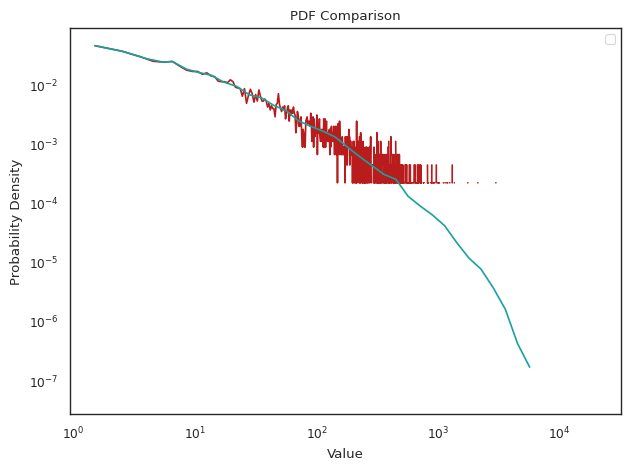

In [40]:
import powerlaw
figure = powerlaw.plot_pdf(aggregated['counts'], linear_bins=True, color=custom_palette[1])
powerlaw.plot_pdf(aggregated['counts'], color=custom_palette[0], ax=figure)

figure.set_ylabel("p(X)")
figure.set_xlabel("Comment Counts")
figure.set_title("Power-law distribution of Comment Counts per Article")

plt.legend()
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title("PDF Comparison")
utils.plot(PRINT_PLOTS, "powerlaw", plt)


In [7]:

fit = powerlaw.Fit(aggregated['counts'])
print("Steepness of the power-law distribution: ", fit.power_law.alpha)
print("Minimum value of the power-law distribution: ", fit.power_law.xmin)
R, p = fit.distribution_compare('power_law', 'lognormal')
print("\nComparison between power law and log normal")
print("R value: ", R, "\nP-value:", p)

Calculating best minimal value for power law fit
Steepness of the power-law distribution:  2.883448153613991
Minimum value of the power-law distribution:  810.0

Comparison between power law and log normal
R value:  -1.0722546827641972 
P-value: 0.5102624560965277


/tmp/ipykernel_828/3006405321.py:13: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, y_max)  # Set y-axis from 0 to max of current range


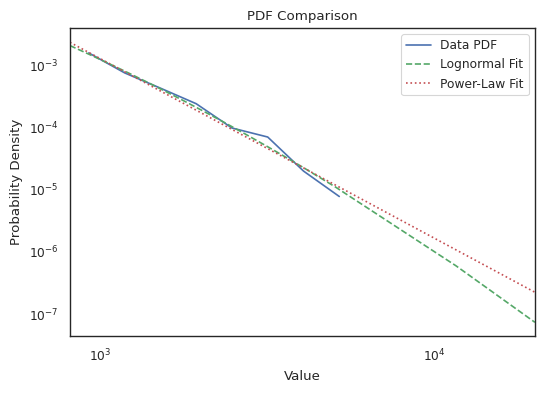

In [ ]:

plt.figure(figsize=(6,4))
fit.plot_pdf(color='b', label="Data PDF")
fit.lognormal.plot_pdf(color='g', linestyle='--', label="Lognormal Fit")
fit.power_law.plot_pdf(color='r', linestyle=':', label="Power-Law Fit")

x_min, x_max = min(fit.data), max(fit.data)
plt.xlim(x_min, x_max)

y_min, y_max = plt.ylim()
plt.ylim(0, y_max)

plt.legend()
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title("PDF Comparison")
plt.show()

## Extract Data under consideration of the Data Distribution
As the distribution of the comments is somewhat lognormal, we partition the dataset into bins of 0-10, 10-100, 100-1000 comments to account for all types of comment sections


In [9]:
# Try to load the variable
try:
  complete = pd.read_pickle(TEMP_PATH + "complete.pkl")
  overview = pd.read_pickle(TEMP_PATH + "overview.pkl")

  scores_log_bin_0 = pd.read_pickle(TEMP_PATH + "scores_log_bin_0.pkl")
  scores_log_bin_1 = pd.read_pickle(TEMP_PATH + "scores_log_bin_1.pkl")
  scores_log_bin_2 = pd.read_pickle(TEMP_PATH + "scores_log_bin_2.pkl")
  scores_log_bins = [scores_log_bin_0, scores_log_bin_1, scores_log_bin_2]

  sample_log_bin_0 = pd.read_pickle(TEMP_PATH + "sample_log_bin_0.pkl")
  sample_log_bin_1 = pd.read_pickle(TEMP_PATH + "sample_log_bin_1.pkl")
  sample_log_bin_2 = pd.read_pickle(TEMP_PATH + "sample_log_bin_2.pkl")
  sample_log_bins = [sample_log_bin_0, sample_log_bin_1, sample_log_bin_2]

  overview_log_bin_0 = pd.read_pickle(TEMP_PATH + "overview_log_bin_0.pkl")
  overview_log_bin_1 = pd.read_pickle(TEMP_PATH + "overview_log_bin_1.pkl")
  overview_log_bin_2 = pd.read_pickle(TEMP_PATH + "overview_log_bin_2.pkl")
  overviews = [overview_log_bin_0, overview_log_bin_1, overview_log_bin_2]

except FileNotFoundError:

  # parttion into logarithmic bins
  log_bin_0 = aggregated[aggregated['counts'] < 10]
  log_bin_1 = aggregated[(aggregated['counts'] >= 10) & (aggregated['counts'] < 100)]
  log_bin_2 = aggregated[(aggregated['counts'] >= 100) & (aggregated['counts'] < 1000)]

  sample_log_bin_0 = log_bin_0.sample(n=EVAL_BIN_SIZE, random_state=42)
  sample_log_bin_1 = log_bin_1.sample(n=EVAL_BIN_SIZE, random_state=42)
  sample_log_bin_2 = log_bin_2.sample(n=EVAL_BIN_SIZE, random_state=42)
  sample_log_bins = [sample_log_bin_0, sample_log_bin_1, sample_log_bin_2]
  scores_log_bin_0 = []
  scores_log_bin_1 = []
  scores_log_bin_2 = []
  scores_log_bins = [scores_log_bin_0, scores_log_bin_1, scores_log_bin_2]
  overviews = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

  for i, bin in enumerate(sample_log_bins):
      for _, sample in bin.iterrows():
        article_id = sample["Article_Id"]
        comments, comments_matched_to_metadata = eval_gen.extract_comments_with_metadata(article_id)
        scores = eval_gen.calculate_all_scores(comments_matched_to_metadata, comments, ranker)
        scores_log_bins[i].append(scores)
        comments = len(comments_matched_to_metadata)
        warnings = scores["Warning"].eq("Warning").sum()
        average_civiscore = scores["CiviScore"].mean()
        average_civiscore_without_warnings = scores[scores["Warning"].ne("Warning")]["CiviScore"].mean()
        new_row = pd.DataFrame({
            "article_id": [article_id],
            "comments": [comments],
            "warnings": [warnings],
            "average_civiscore": [average_civiscore],
            "warning_proportion": [warnings / comments],
            "average_civiscore_without_warnings": [average_civiscore_without_warnings],
        })
        overviews[i] = pd.concat([overviews[i], new_row], ignore_index=True)
  complete = pd.DataFrame()
  overview = pd.DataFrame()
  for i, bin in enumerate(scores_log_bins):
    overview = pd.concat([overview, overviews[i]], ignore_index=True)
    for scores in bin:
      complete = pd.concat([complete, scores], ignore_index=True)
      
  complete.to_pickle(TEMP_PATH + "complete.pkl")
  overview.to_pickle(TEMP_PATH + "overview.pkl")

  pd.to_pickle(scores_log_bins[0], TEMP_PATH + "scores_log_bin_0.pkl")
  pd.to_pickle(scores_log_bins[1], TEMP_PATH + "scores_log_bin_1.pkl")
  pd.to_pickle(scores_log_bins[2], TEMP_PATH + "scores_log_bin_2.pkl")

  pd.to_pickle(sample_log_bins[0], TEMP_PATH + "sample_log_bin_0.pkl")
  pd.to_pickle(sample_log_bins[1], TEMP_PATH + "sample_log_bin_1.pkl")
  pd.to_pickle(sample_log_bins[2], TEMP_PATH + "sample_log_bin_2.pkl")

  pd.to_pickle(overviews[0], TEMP_PATH + "overview_log_bin_0.pkl")
  pd.to_pickle(overviews[1], TEMP_PATH + "overview_log_bin_1.pkl")
  pd.to_pickle(overviews[2], TEMP_PATH + "overview_log_bin_2.pkl")


## General overview

For this, the total comments on articles and their respective total and negative votes.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


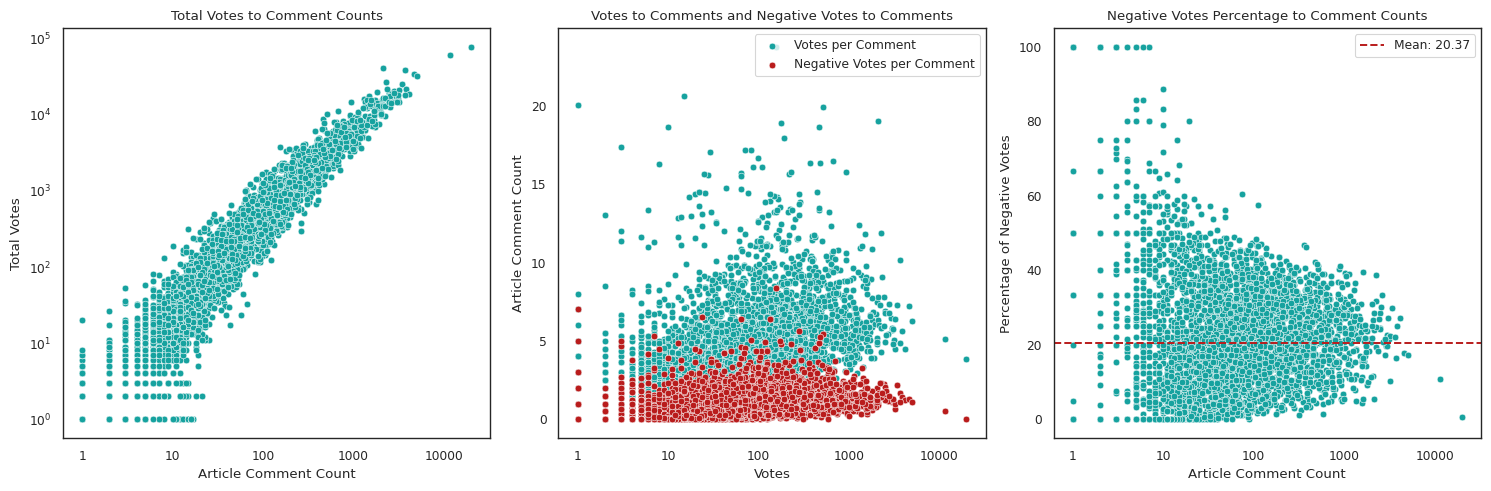

In [41]:
winsorized = np.clip(aggregated['counts'], aggregated['counts'].quantile(0.01), aggregated['counts'].quantile(0.99))

f, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(data=aggregated, x='counts', y='Votes_Total', ax=ax[0])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Total Votes to Comment Counts')
ax[0].set(xlabel='Article Comment Count', ylabel='Total Votes')

sns.scatterplot(data=aggregated, x='counts', y='VotesToComments', ax=ax[1], label='Votes per Comment')
sns.scatterplot(data=aggregated, x='counts', y='NegVotesToComments', ax=ax[1], label='Negative Votes per Comment')
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set(xlabel='Votes', ylabel='Article Comment Count')
ax[1].set_title('Votes to Comments and Negative Votes to Comments')

sns.scatterplot(data=aggregated, x='counts', y='NegVotesPercentage', ax=ax[2])
ax[2].set_xscale('log')
ax[2].set_title('Negative Votes Percentage to Comment Counts')
ax[2].set(xlabel='Article Comment Count', ylabel='Percentage of Negative Votes')
# Mark the average
mean_neg_votes_percentage = aggregated['NegVotesPercentage'].mean()
ax[2].axhline(mean_neg_votes_percentage, color=custom_palette[1], linestyle='--', label=f'Mean: {mean_neg_votes_percentage:.2f}', linewidth=1.4)
ax[2].legend()

for ax_row in ax:
    ax_row.get_xaxis().set_major_formatter(plt.ScalarFormatter())

utils.plot(PRINT_PLOTS, "overview", plt)

## Visualizing typical cases
For visualizing typical cases we first examine a range of articles pseudorandomly sampled between the 40th and the 60th quantile of comment counts, to get an impression of the typical case.

In [11]:
#randomly sample ARTICLES_TO_OVERVIEW articles from the iqr
iqr = aggregated[(aggregated['counts'] >= aggregated['counts'].quantile(0.4)) & (aggregated['counts'] <= aggregated['counts'].quantile(0.6))]
articles_to_evaluate = iqr.sample(n=ARTICLES_TO_OVERVIEW, random_state=2)

In [12]:
results = []
overview_typical = pd.DataFrame()

for i, row in articles_to_evaluate.iterrows():
    article_id = row["Article_Id"]
    comments, comments_matched_to_metadata = eval_gen.extract_comments_with_metadata(article_id)
    scores = eval_gen.calculate_all_scores(comments_matched_to_metadata, comments, ranker)
    results.append(scores)
    new_row = pd.DataFrame({
        "article_id": [article_id],
        "comments": [len(comments_matched_to_metadata)],
        "warning": [scores["Warning"].eq("Warning").sum()],
        "average_civiscore": [scores["CiviScore"].mean()],
    })
    overview_typical = pd.concat([overview_typical, new_row], ignore_index=True)
overview_typical["warning_proportion"] = (overview_typical["warning"] / overview_typical["comments"])

In [13]:
overview_typical["article_id"] = overview_typical["article_id"].astype(str)
print(overview_typical["article_id"])
to_review = results[2]

0    2000102847889.0
1    2000103860777.0
2    2000103419433.0
3    2000102845281.0
4    2000103425089.0
Name: article_id, dtype: object


### Showcase of Ranking movement
Here we look at how the comments move when reranked with civirank vs the reddit scoring by drawing lines between each placement.

Hidden comment for article  2000102847889.0 : sorry, sollte rot sein. Im Grunde genommen wäre die Aussage richtig. Aber,... leider ist dem nicht so im Land deines Führers. Schade nur, dass Sie dort nicht leben wollen.
Top rated CiviRank comment for article  2000102847889.0 : CHP will die Präsidenten- und Parlamentswahlen vom Juni 2018 sowie die Kommunalwahl in allen 39 Istanbuler Bezirken annullieren lassen. Damit reagiert sie auf die Bürgermeisterwahl in Istanbul von Ende März: Diese hatte die CHP knapp mit 13.000 Stimmen Vorsprung vor der islamisch-konservativen AKP von Präsident Erdoğan gewonnen. Die oberste Wahlbehörde hatte die Wahl allerdings auf Antrag der AKP annulliert. Zur Begründung ihrer Entscheidung für eine Neuwahl in Istanbul hatte die Wahlbehörde am Montag angegeben, nicht alle Helfer an den Wahlurnen seien Staatsbedienstete gewesen – so wie es die Vorschriften vorsähen. Nach Angaben der Opposition sind die Helfer bei den anderen Wahlen in derselben Weise nominiert word

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


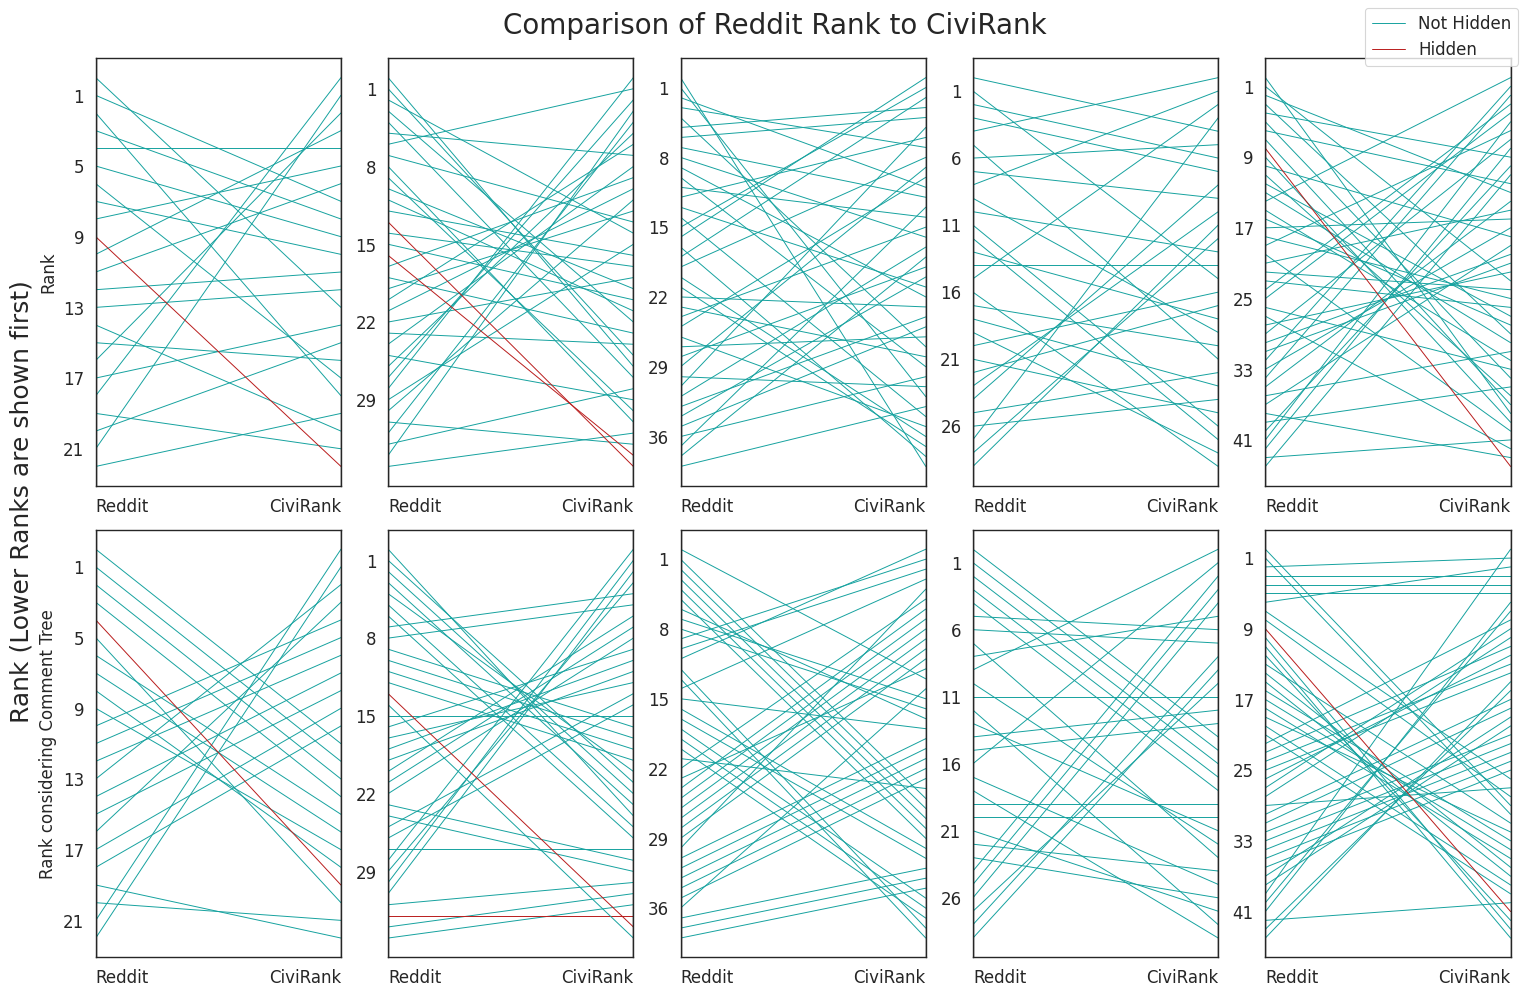

In [47]:
import matplotlib.patches as patches
fig, axs = plt.subplots(2, ARTICLES_TO_OVERVIEW, figsize=(15, 10))
top_n = 1
filtered_results = [result for result in results if 20 < len(result) < 150]
for i, (result, (i, overview_row)) in enumerate(zip(filtered_results[:ARTICLES_TO_OVERVIEW], overview_typical.iterrows())):
  civirank_tree = eval_gen.build_tree_sorted_by(result, sort_by="CiviRank").reset_index(names=['CiviIndex']).loc[:, ['CiviIndex', 'Post_Id', 'Warning']]
  reddit_rank_tree = eval_gen.build_tree_sorted_by(result, sort_by="Reddit_Score_Rank").reset_index(names=['Reddit_Index']).loc[:, ['Reddit_Index', 'Post_Id']]
  trees_compared = pd.merge(civirank_tree, reddit_rank_tree, on='Post_Id', how='inner', validate="one_to_one")
  parallel_coordinates(result[[ "Reddit_Score_Rank", "CiviRank","Warning"]], class_column="Warning", colormap=custom_heatmap_cmap, linewidth=0.7, ax=axs[0, i])
  parallel_coordinates(trees_compared[["Reddit_Index", "CiviIndex", "Warning"]], class_column="Warning", colormap=custom_heatmap_cmap, linewidth=0.7, ax=axs[1, i])
  for ax in [axs[0, i], axs[1, i]]:
    ax.invert_yaxis()  # Reverse the y-axis
    ax.set_yticks(range(1, max(result[["CiviRank", "Reddit_Score_Rank"]].max()) + 1, int(max(result[["CiviRank", "Reddit_Score_Rank"]].max()) / 5)))  # Custom y-ticks
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Reddit', 'CiviRank'])
    for i, label in enumerate(ax.get_xticklabels()):
      label.set_ha('left') if i == 0 else label.set_ha('right')
    ax.grid(False)
    #disable individual legends
    ax.get_legend().remove()

  worst_rated = result.nlargest(top_n, 'CiviRank')
  hidden_comments = result[result["Warning"] == "Warning"]
  best_rated = result.nsmallest(top_n, 'CiviRank')
  count = 0
  for j, row in hidden_comments.iterrows():
    print("Hidden comment for article ", overview_row["article_id"], ":", row["text"])
  # for j, row in worst_rated.iterrows():
  #   print("Worst rated comment for article ", overview_row["article_id"], ":", row["text"])
  for j, row in best_rated.iterrows():
    print("Top rated CiviRank comment for article ", overview_row["article_id"], ":", row["text"])

axs[0,0].set_ylabel('Rank', fontsize=12)
axs[1,0].set_ylabel('Rank considering Comment Tree', fontsize=12)

#set a global y label
fig.text(-0.01, 0.5, 'Rank (Lower Ranks are shown first)', fontsize=18, va='center', rotation='vertical')

handles, labels = axs[0, 1].get_legend_handles_labels()
fig.legend(handles, ['Not Hidden', 'Hidden'], loc='upper right', fontsize=12)
fig.suptitle('Comparison of Reddit Rank to CiviRank', fontsize=20, y=0.99)
#axs[0, 0].add_patch(patches.Rectangle((-0.3, -0.1), 0.7, 0.5, transform=axs[0, 0].transAxes, color="white"))

for ax in axs.flat:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(12)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
utils.plot(PRINT_PLOTS, "rank_showcase", plt)


### Plot distribution of Civiscores

Median in CiviScores:  0.12063251389545718
Mean in CiviScores:  0.10577382834244216
IQR in CiviScores:  0.04905073213944925 0.17292762746566387
10th quantile in CiviScores:  -0.02939033011971154
5th quantile in CiviScores:  -0.08119113163022329
4th quantile in CiviScores:  -0.09470529470529478
3rd quantile in CiviScores:  -0.10767453431687597


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


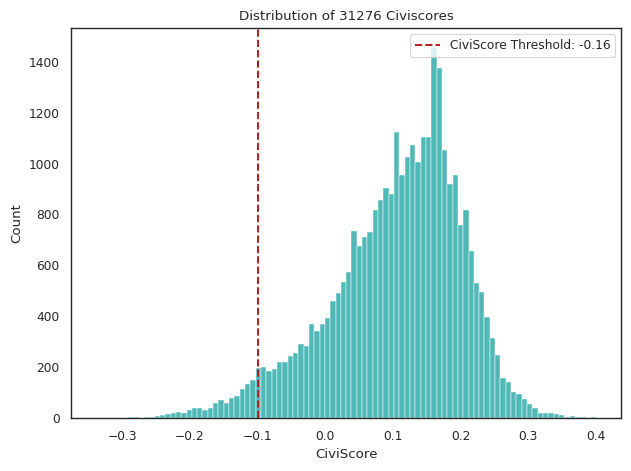

Comments ranked:  31276


In [48]:
g = sns.histplot(data=complete['CiviScore'])
plt.axvline(-0.1, color=custom_palette[1], linestyle='--', label=f'CiviScore Threshold: -0.16', linewidth=1.4)

print("Median in CiviScores: ", complete['CiviScore'].median())
print("Mean in CiviScores: ", complete['CiviScore'].mean())
print("IQR in CiviScores: ", complete['CiviScore'].quantile(0.25), complete['CiviScore'].quantile(0.75))
print("10th quantile in CiviScores: ", complete['CiviScore'].quantile(0.1))
print("5th quantile in CiviScores: ", complete['CiviScore'].quantile(0.05))
print("4th quantile in CiviScores: ", complete['CiviScore'].quantile(0.04))
print("3rd quantile in CiviScores: ", complete['CiviScore'].quantile(0.03))


plt.legend()
plt.title(f"Distribution of {len(complete)} Civiscores")
utils.plot(PRINT_PLOTS, "civiscores_distribution", plt)
print("Comments ranked: ", len(complete))



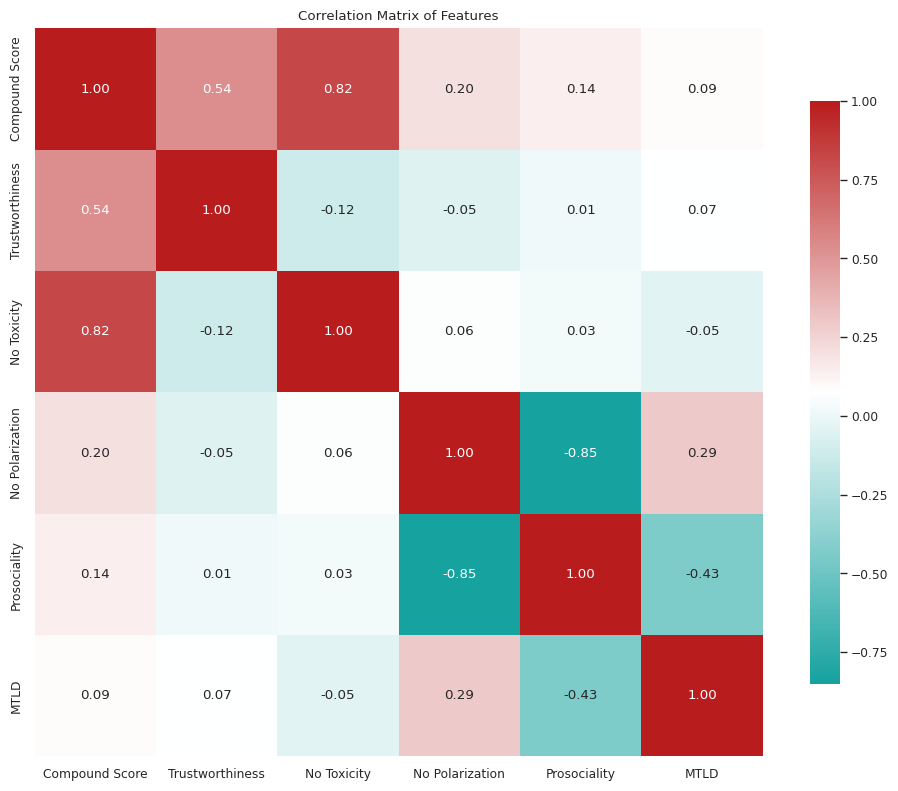

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


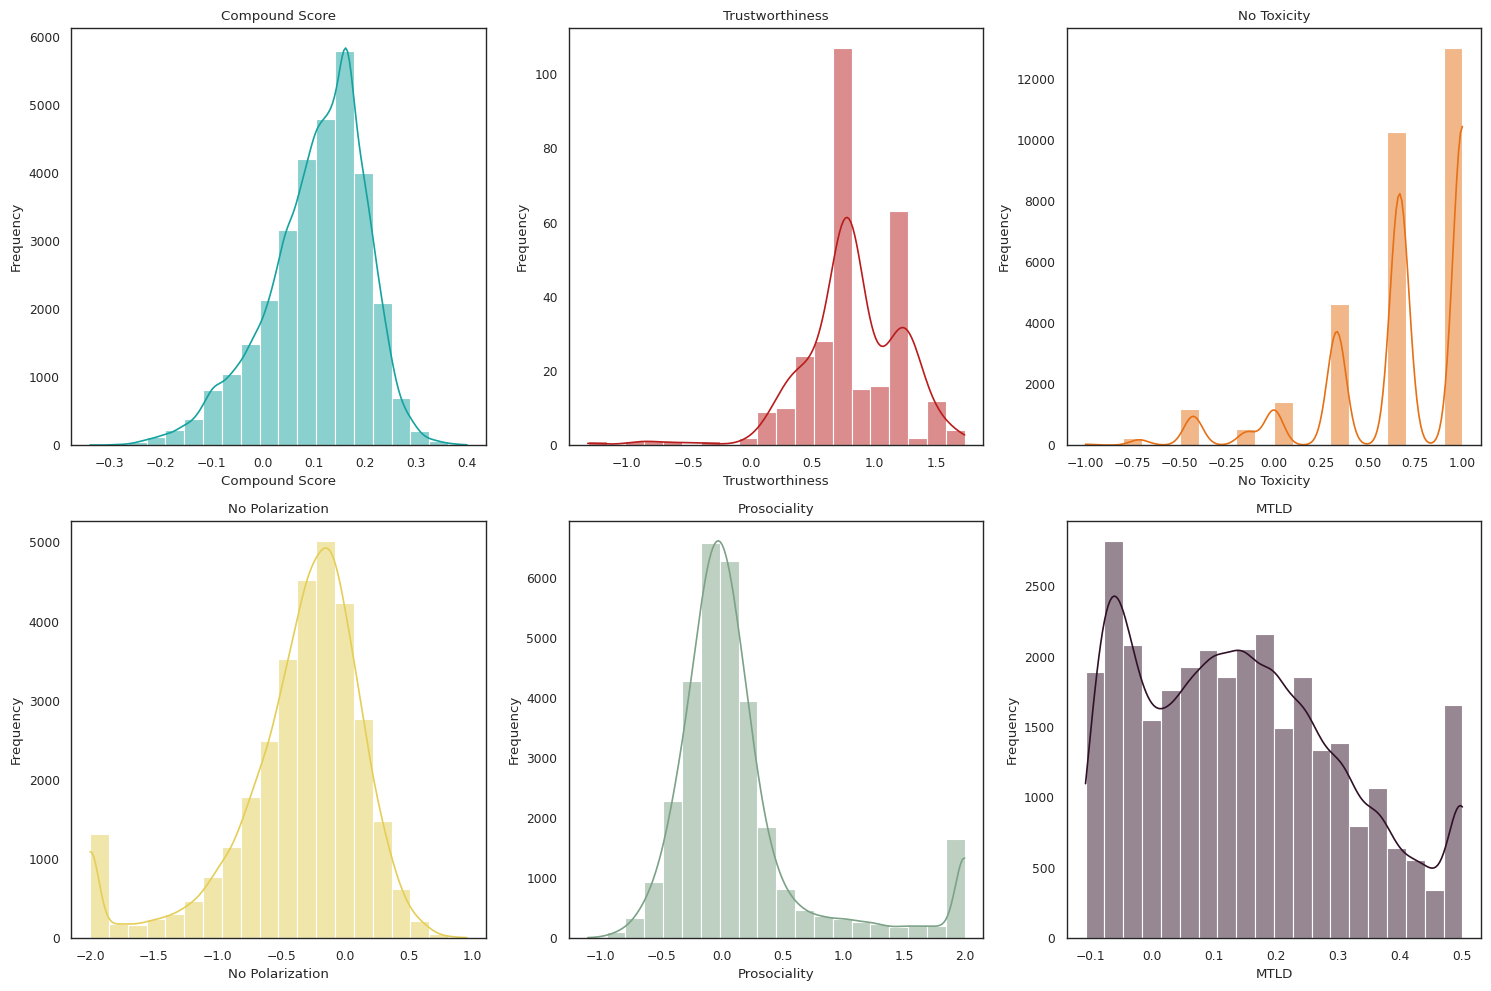

In [52]:
from matplotlib.colors import LinearSegmentedColormap
subset = complete[["compound_score","trustworthiness", "no_toxicity", "no_polarization", "prosociality", "mtld"]].copy()
names = ["Compound Score", "Trustworthiness", "No Toxicity", "No Polarization", "Prosociality", "MTLD"]
plt.figure(figsize=(10, 8))

color_list = [custom_palette[0], 'white', custom_palette[1]]
custom_heatmap_cmap = LinearSegmentedColormap.from_list(
    "custom_primary_secondary", color_list, N=256
)


sns.heatmap(subset.corr(), annot=True, fmt=".2f", cmap=custom_heatmap_cmap, square=True, xticklabels=names, yticklabels=names, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Features")

utils.plot(PRINT_PLOTS, "correlation_matrix", plt)
# Plot the distribution of each feature
plt.figure(figsize=(15, 10))
for i, (column, name) in enumerate(zip(subset.columns, names)):
    plt.subplot(2, 3, i + 1)
    sns.histplot(subset[column], bins=20, kde=True, color=custom_palette[i])
    plt.title(name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
utils.plot(PRINT_PLOTS, "feature_distribution", plt)

### Plot the percentage of hidden comments per bin

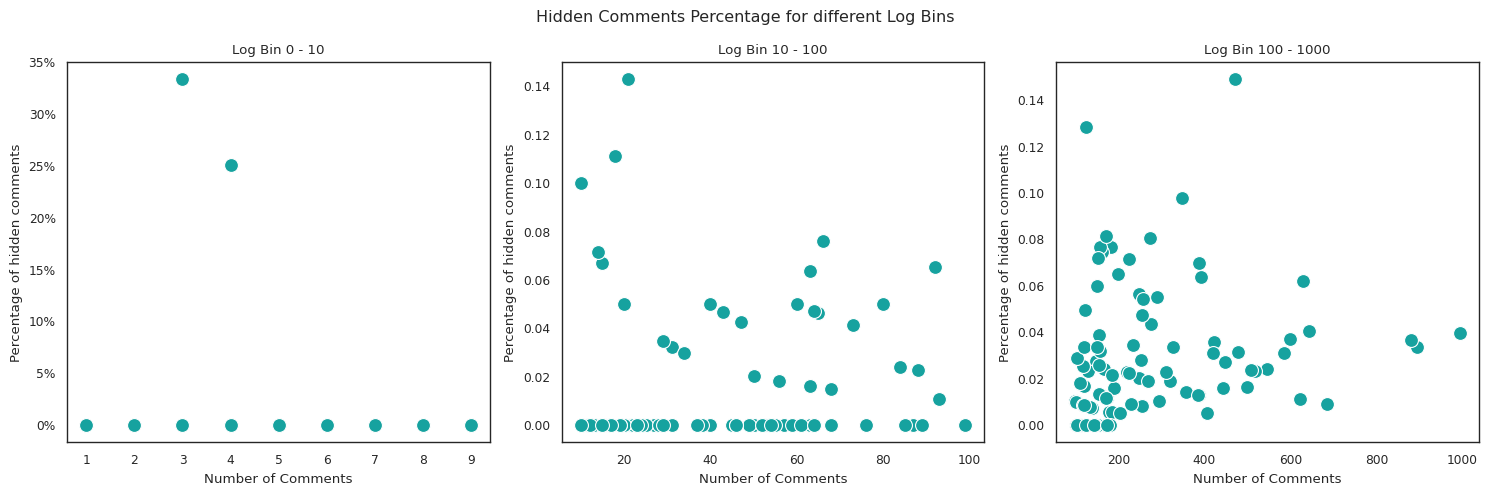

Hidden comments percentage overall: 2.97%


In [53]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, bin in enumerate(overviews):
    sns.scatterplot(data=bin, x='comments', y='warning_proportion', ax=axs[i], s=100)
    axs[i].set_xlabel('Number of Comments')
    axs[i].set_ylabel('Percentage of hidden comments')
    axs[i].set_title(f'Log Bin {i if i == 0 else "1"+"0"*i} - 10{"0"*i}')
    axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
fig.suptitle('Hidden Comments Percentage for different Log Bins')
utils.plot(PRINT_PLOTS, "warnings_per_bin", plt)
hidden_comment_count = complete[complete["Warning"] == "Warning"]
print(f"Hidden comments percentage overall: {hidden_comment_count.shape[0] / complete.shape[0] * 100:.2f}%")

### Plot the average Civiscore with and without hidden Comments per bin

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


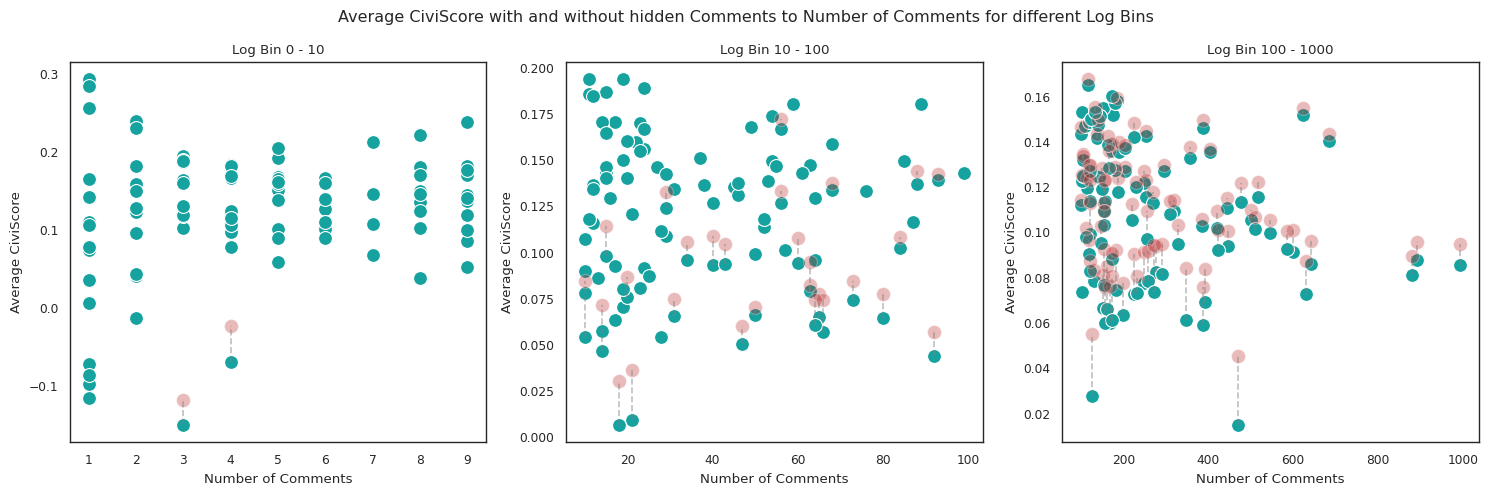

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, bin in enumerate(overviews):
    sns.scatterplot(data=bin, x='comments', y='average_civiscore', ax=axs[i], s=100)
    axs[i].set_xlabel('Number of Comments')
    axs[i].set_ylabel('Average CiviScore')
    axs[i].set_title(f'Log Bin {i if i == 0 else "1"+"0"*i} - 10{"0"*i}')
    bin_only_containing_warnings = bin[bin["warnings"] != 0]
    sns.scatterplot(data=bin_only_containing_warnings, x='comments', y='average_civiscore_without_warnings', ax=axs[i], s=100, alpha=0.3)
    for _, row in bin_only_containing_warnings.iterrows():
        # Find the corresponding row in the original dataset
        original_row = bin[bin['article_id'] == row['article_id']]
        if not original_row.empty:
            axs[i].plot(
                [row['comments'], row['comments']],  # X values remain the same
                [original_row['average_civiscore'].values[0], row['average_civiscore_without_warnings']],  # Connect Y values
                color='gray', linestyle='--', alpha=0.5
            )
fig.suptitle('Average CiviScore with and without hidden Comments to Number of Comments for different Log Bins')
utils.plot(PRINT_PLOTS, "civiscore_per_bin", plt)


### Extract average Scores of Threads and their parents


In [55]:
threads = pd.DataFrame()
thread_counter = 0 
for i, bin in enumerate(scores_log_bins):
  for scores in bin:
    threads = eval_gen.extract_leaves_to_parent_scores(leaves=threads
                                           , scores=scores)

In [56]:
filtered_where_no_warning_but_average_below_0 = threads[(threads["childs_avg_civiscore"] < 0) & (threads["warning"] == False)]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


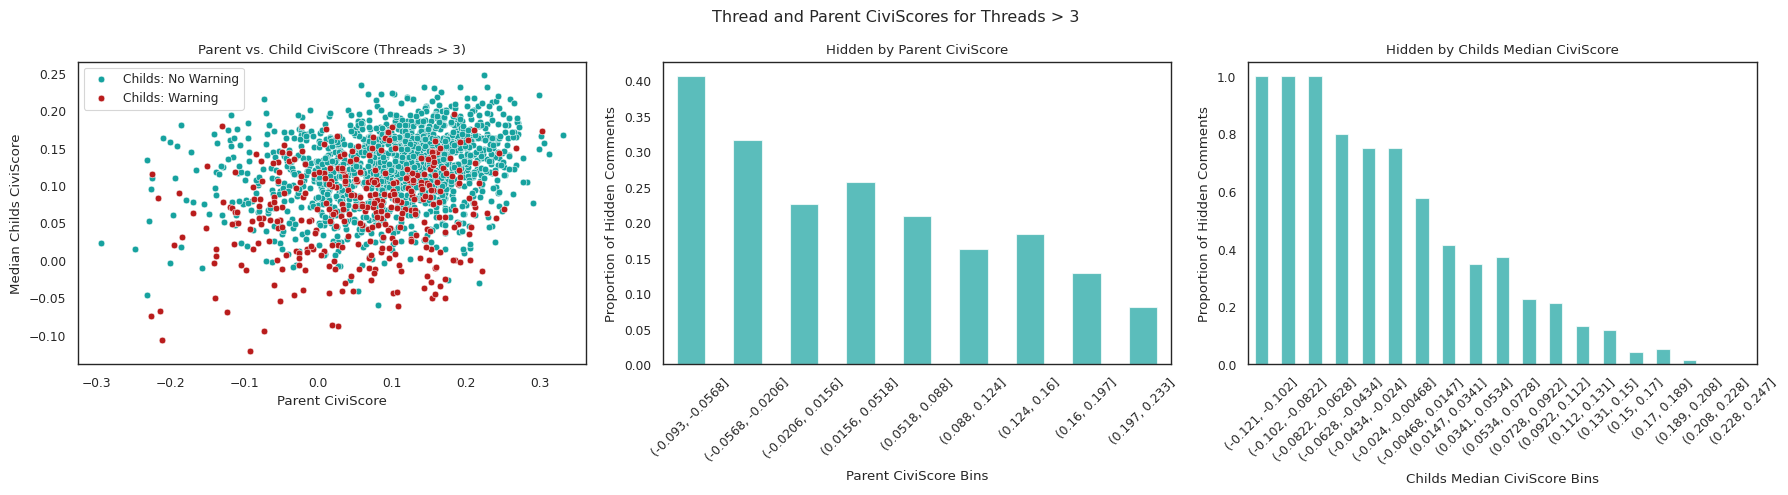

In [57]:
from scipy.stats.mstats import winsorize

comment_threads_greater_than = 3

threads_more_than_five = threads[threads["childs_count"] > comment_threads_greater_than]

fig = plt.figure(figsize=(18, 5))  # wide figure for 3 subplots
ax1 = fig.add_subplot(1, 3, 1)

sns.scatterplot(
    data=threads_more_than_five[~threads_more_than_five["warning"]], 
    x="parent_civiscore",
    y="childs_median_civiscore",
    label="Childs: No Warning",
    ax=ax1
)

sns.scatterplot(
    data=threads_more_than_five[threads_more_than_five["warning"]], 
    x="parent_civiscore",
    y="childs_median_civiscore",
    label="Childs: Warning",
    ax=ax1
)

ax1.set_xlabel("Parent CiviScore")
ax1.set_ylabel("Median Childs CiviScore")
ax1.set_title(f"Parent vs. Child CiviScore (Threads > {comment_threads_greater_than})")
ax1.legend(loc="best")

leaves_for_histogram = threads.copy()
leaves_for_histogram = threads[threads["childs_count"] > comment_threads_greater_than].copy()

leaves_for_histogram['hidden'] = leaves_for_histogram['warning'].eq(True).astype(int)  # Convert warnings to binary (1 for hidden, 0 otherwise)
leaves_for_histogram['parent_civiscore'] = winsorize(leaves_for_histogram['parent_civiscore'], limits=[0.05, 0.05])
leaves_for_histogram['childs_civiscore_winsorized'] = winsorize(leaves_for_histogram['childs_median_civiscore'], limits=[0.05, 0.05])

bins_parent = np.linspace(leaves_for_histogram['parent_civiscore'].min(), leaves_for_histogram['parent_civiscore'].max(), 10)
bins_child = np.linspace(leaves_for_histogram['childs_median_civiscore'].min(), leaves_for_histogram['childs_median_civiscore'].max(), 20)

leaves_for_histogram['parent_bin'] = pd.cut(leaves_for_histogram['parent_civiscore'], bins=bins_parent)
parent_hidden_proportion = leaves_for_histogram.groupby('parent_bin', observed=False)['hidden'].mean()

# Group by bins for childs_avg_civiscore
leaves_for_histogram['child_bin'] = pd.cut(leaves_for_histogram['childs_median_civiscore'], bins=bins_child)
child_hidden_proportion = leaves_for_histogram.groupby('child_bin', observed=False)['hidden'].mean()



ax2 = fig.add_subplot(1, 3, 2)
parent_hidden_proportion.plot(kind="bar", alpha=0.7, ax=ax2)
ax2.set_xlabel("Parent CiviScore Bins")
ax2.set_ylabel("Proportion of Hidden Comments")
ax2.set_title("Hidden by Parent CiviScore")
ax2.tick_params(axis="x", rotation=45)


ax3 = fig.add_subplot(1, 3, 3)
child_hidden_proportion.plot(kind="bar", alpha=0.7, ax=ax3)
ax3.set_xlabel("Childs Median CiviScore Bins")
ax3.set_ylabel("Proportion of Hidden Comments")
ax3.set_title("Hidden by Childs Median CiviScore")
ax3.tick_params(axis="x", rotation=45)

plt.suptitle(f"Thread and Parent CiviScores for Threads > {comment_threads_greater_than}")
utils.plot(PRINT_PLOTS, "civiscore_parent_child", plt)

### Compare total Engagment (Up and Downvotes) to absolute score

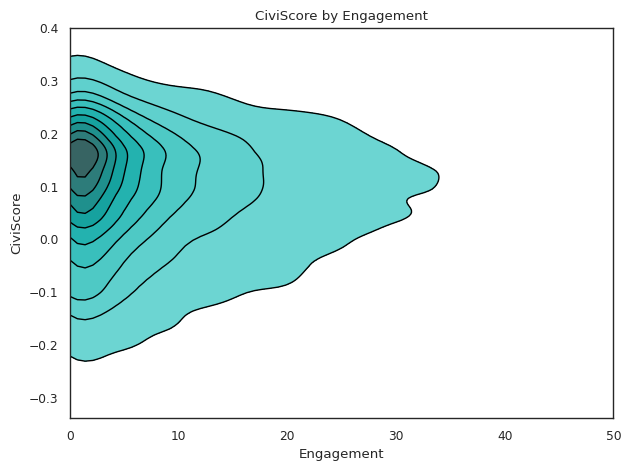

In [58]:
complete["Engagement"] = complete["Votes_Pos"] + complete["Votes_Neg"]
complete["Abs_Score"] = complete["CiviScore"]

ax = sns.kdeplot(data=complete, x='Engagement', y='Abs_Score', cut=0, fill=True)
ax = sns.kdeplot(data=complete, x='Engagement', y='Abs_Score', cut=0, fill=False, linewidths=1,      # Line thickness
    color='black', )
ax.set_xlabel("Engagement")
ax.set_ylabel("CiviScore")
ax.set_title("CiviScore by Engagement")
plt.xlim(0, 50) 
utils.plot(PRINT_PLOTS, "civiscore_engagement", plt)

### Examine downvote behaviour

4839
NegVotesPercentage_Category
Low (<50%)     0.105290
High (>50%)    0.091193
Name: CiviScore, dtype: float64


/tmp/ipykernel_828/2293714771.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_civiscore = high_engagement_posts.groupby("NegVotesPercentage_Category")["CiviScore"].median()


Text(0.5, 1.0, 'Negative Votes Percentage to CiviScore for comments with more than 10 votes')

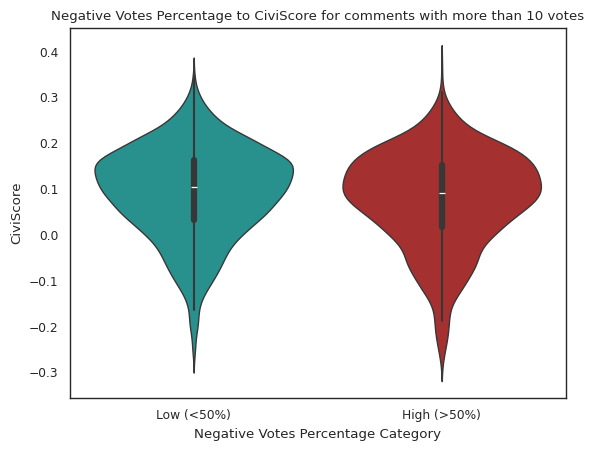

In [59]:
#plot the percentage of negative votes to the civiscore
high_engagement_posts = complete[(complete["Votes_Neg"] + complete["Votes_Pos"]) > 10].copy()
print(len(high_engagement_posts))
high_engagement_posts["NegVotesPercentage"] = (high_engagement_posts["Votes_Neg"] / (high_engagement_posts["Votes_Neg"] + high_engagement_posts["Votes_Pos"])) * 100
high_engagement_posts["NegVotesPercentage_Category"] = pd.cut(
    high_engagement_posts["NegVotesPercentage"],
    bins=[-1, 50, 100],  # Custom bins
    labels=["Low (<50%)", "High (>50%)"]
)
median_civiscore = high_engagement_posts.groupby("NegVotesPercentage_Category")["CiviScore"].median()
print(median_civiscore)
ax = sns.violinplot(data=high_engagement_posts, x="NegVotesPercentage_Category", y="CiviScore", hue="NegVotesPercentage_Category", palette=custom_palette[:2])
ax.set_xlabel("Negative Votes Percentage Category")
ax.set_title("Negative Votes Percentage to CiviScore for comments with more than 10 votes")


4839
NegVotesPercentage_Category
Low (<25%)         0.107229
Medium (25-50%)    0.087075
Medium (50-75%)    0.080447
High (>75%)        0.098092
Name: CiviScore, dtype: float64


/tmp/ipykernel_828/2627761398.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_civiscore = high_engagement_posts.groupby("NegVotesPercentage_Category")["CiviScore"].median()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


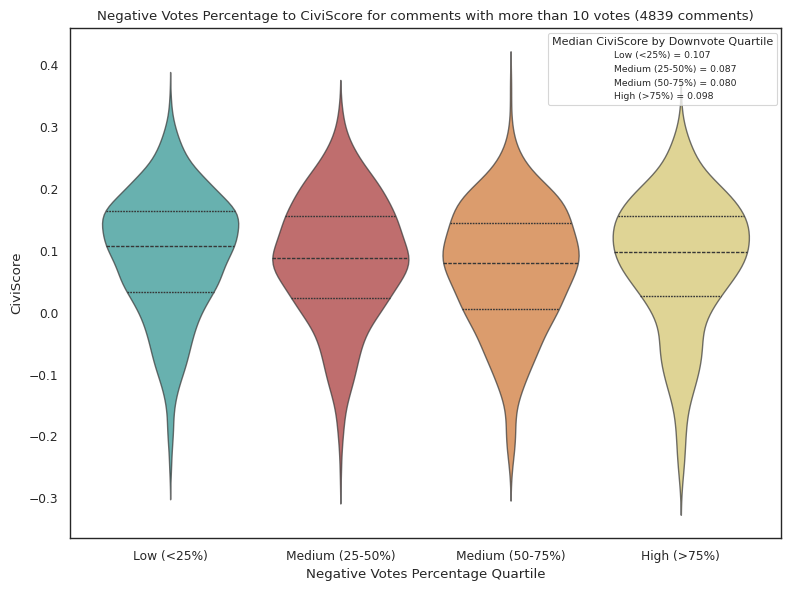

In [72]:
#plot the percentage of negative votes to the civiscore
high_engagement = 10
high_engagement_posts = complete[(complete["Votes_Neg"] + complete["Votes_Pos"]) > high_engagement].copy()
print(len(high_engagement_posts))
high_engagement_posts["NegVotesPercentage"] = (high_engagement_posts["Votes_Neg"] / (high_engagement_posts["Votes_Neg"] + high_engagement_posts["Votes_Pos"])) * 100
high_engagement_posts["NegVotesPercentage_Category"] = pd.cut(
    high_engagement_posts["NegVotesPercentage"],
    bins=[-1, 25, 50, 75,100],  # Custom bins
    labels=["Low (<25%)", "Medium (25-50%)", "Medium (50-75%)", "High (>75%)"]
)
#calculate the median civiscore for each category
median_civiscore = high_engagement_posts.groupby("NegVotesPercentage_Category")["CiviScore"].median()
print(median_civiscore)

plt.figure(figsize=(8, 6))
ax = sns.violinplot(data=high_engagement_posts, x="NegVotesPercentage_Category", y="CiviScore", hue="NegVotesPercentage_Category", palette=custom_palette[:4], inner="quart", alpha=0.7)
for category in median_civiscore.index:
    label = f"{category} = {median_civiscore[category]:.3f}"
    ax.plot([], [], ' ', label=label)
ax.legend(title="Median CiviScore by Downvote Quartile", fontsize="x-small", title_fontsize='small',)
ax.set_xlabel("Negative Votes Percentage Quartile")
ax.set_title(f"Negative Votes Percentage to CiviScore for comments with more than {high_engagement} votes ({len(high_engagement_posts)} comments)")
utils.plot(PRINT_PLOTS, "negative_votes_to_civiscore", plt)


In [61]:
correlation = high_engagement_posts["NegVotesPercentage"].corr(high_engagement_posts["CiviScore"])
print(f"Correlation between Negative Votes Percentage and CiviScore: {correlation:.3f}")

Correlation between Negative Votes Percentage and CiviScore: -0.075


# Evaluate the most commented article in the dataset
As this dataset is comprised of data from May 2019, it also includes "the article" that first described the events around the [Ibiza-Affair](https://en.wikipedia.org/wiki/Ibiza_affair). This article is potentially a outlier in this dataset, as it has been commented on significantly more than all other articles, which makes the civility of this comment section especially interesting.

In [62]:

most_commented_on = aggregated.sort_values(by="counts", ascending=False).iloc[0]["Article_Id"]
try:
    most_commented_on_comments_matched_to_metadata = pd.read_pickle(TEMP_PATH+"most_commented_on_comments_matched_to_metadata.pkl")
    most_commented_on_scores = pd.read_pickle(TEMP_PATH+"most_commented_on_scores.pkl")
    print("Loaded stored variables successfully!")
except (FileNotFoundError, EOFError):
    # get top article
    most_commented_on_comments, most_commented_on_comments_matched_to_metadata = eval_gen.extract_comments_with_metadata(most_commented_on)
    most_commented_on_scores = eval_gen.calculate_all_scores(most_commented_on_comments_matched_to_metadata, most_commented_on_comments, ranker)

    # store the variables
    most_commented_on_comments_matched_to_metadata.to_pickle(TEMP_PATH+"most_commented_on_comments_matched_to_metadata.pkl")
    most_commented_on_scores.to_pickle(TEMP_PATH+"most_commented_on_scores.pkl")
    print("Stored variables successfully!")



Loaded stored variables successfully!


Comments in most commented on article:  19973
Average CiviScore in most commented on article:  0.14555713603195777
Median CiviScore in most commented on article:  0.16347128503083633


<Axes: xlabel='CiviScore', ylabel='Count'>

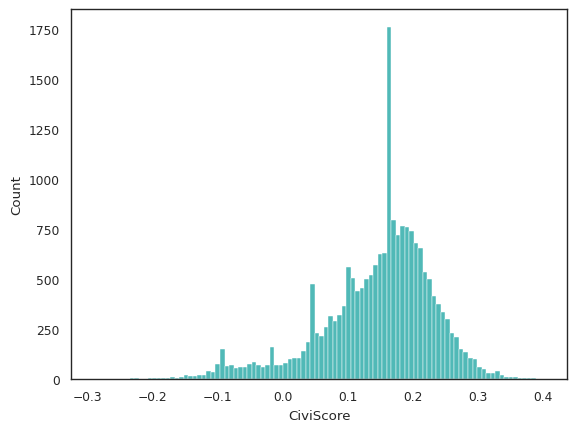

In [63]:
print("Comments in most commented on article: ", len(most_commented_on_comments_matched_to_metadata))
print("Average CiviScore in most commented on article: ", most_commented_on_scores["CiviScore"].mean())
print("Median CiviScore in most commented on article: ", most_commented_on_scores["CiviScore"].median())

sns.histplot(data=most_commented_on_scores, x='CiviScore', bins=100)

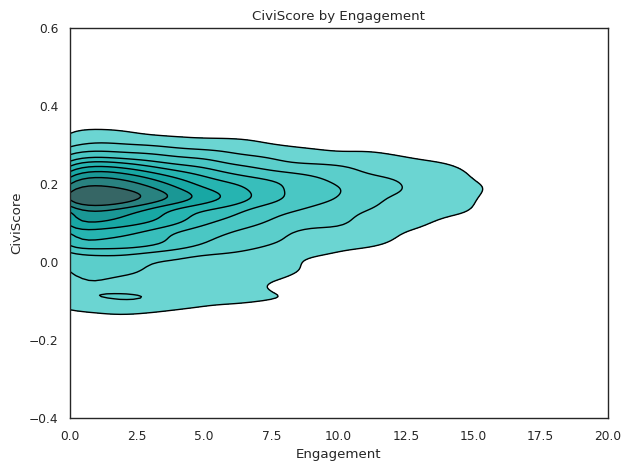

In [64]:
most_commented_on_scores["Engagement"] = most_commented_on_scores["Votes_Pos"] + most_commented_on_scores["Votes_Neg"]
most_commented_on_scores["Abs_Score"] = most_commented_on_scores["CiviScore"]
ax = sns.kdeplot(data=most_commented_on_scores, x='Engagement', y='Abs_Score', cut=0, fill=True)
ax = sns.kdeplot(data=most_commented_on_scores, x='Engagement', y='Abs_Score', cut=0, fill=False, linewidths=1,      # Line thickness
    color='black', )

ax.set_xlabel("Engagement")
ax.set_ylabel("CiviScore")
ax.set_title("CiviScore by Engagement")
plt.xlim(0, 20)
plt.ylim(-0.4, 0.6)
utils.plot(PRINT_PLOTS, "outlier_civiscore_engagement", plt)

In [65]:
outlier = pd.DataFrame({
        "article_id": [most_commented_on],
        "comments": [len(most_commented_on_comments_matched_to_metadata)],
        "warning": [most_commented_on_scores["Warning"].eq("Warning").sum()],
        "average_civiscore": [most_commented_on_scores["CiviScore"].mean()],
        "warning_proportion": [most_commented_on_scores["Warning"].eq("Warning").sum() / len(most_commented_on_scores)]
    })

print("The hidden comments proportion of the most commented on article is: ", outlier["warning_proportion"].values[0])
print("The average CiviScore of the most commented on article is: ", outlier["average_civiscore"].values[0])

outlier_threads = pd.DataFrame()

outlier_threads = eval_gen.extract_leaves_to_parent_scores(leaves=outlier_threads, scores=most_commented_on_scores)

The hidden comments proportion of the most commented on article is:  0.012316627447053523
The average CiviScore of the most commented on article is:  0.14555713603195777


Mean of Parents CiviScores:  0.14716926461825092
Mean of Child Comment CiviScores:  0.14441556246249265


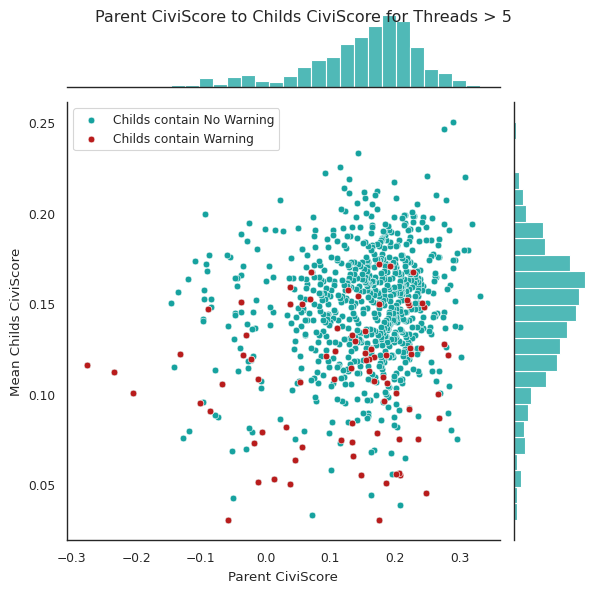

In [66]:
threads_more_than_five = outlier_threads[outlier_threads["childs_count"] > 5]
mean_parents = threads_more_than_five['parent_civiscore'].mean()
mean_childs = threads_more_than_five['childs_avg_civiscore'].mean()
print("Mean of Parents CiviScores: ", mean_parents)
print("Mean of Child Comment CiviScores: ", mean_childs)

g = sns.jointplot(
    data=threads_more_than_five,
    x='parent_civiscore',
    y='childs_avg_civiscore',
    palette=custom_palette,
    kind='scatter',
    label='Childs contain No Warning'
)

sns.scatterplot(
    data=threads_more_than_five[threads_more_than_five['warning'].eq(True)],
    x='parent_civiscore',
    y='childs_avg_civiscore',
    color=custom_palette[1],
    label='Childs contain Warning',
    ax=g.ax_joint,
)

g.ax_joint.set_xlabel('Parent CiviScore')
g.ax_joint.set_ylabel('Mean Childs CiviScore')
g.figure.suptitle('Parent CiviScore to Childs CiviScore for Threads > 5')

g.ax_joint.set_xlabel('Parent CiviScore')
g.ax_joint.set_ylabel('Mean Childs CiviScore')

g.ax_joint.legend(loc='best')
#utils.plot(PRINT_PLOTS, "outlier_civiscore_parent_child", plt)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


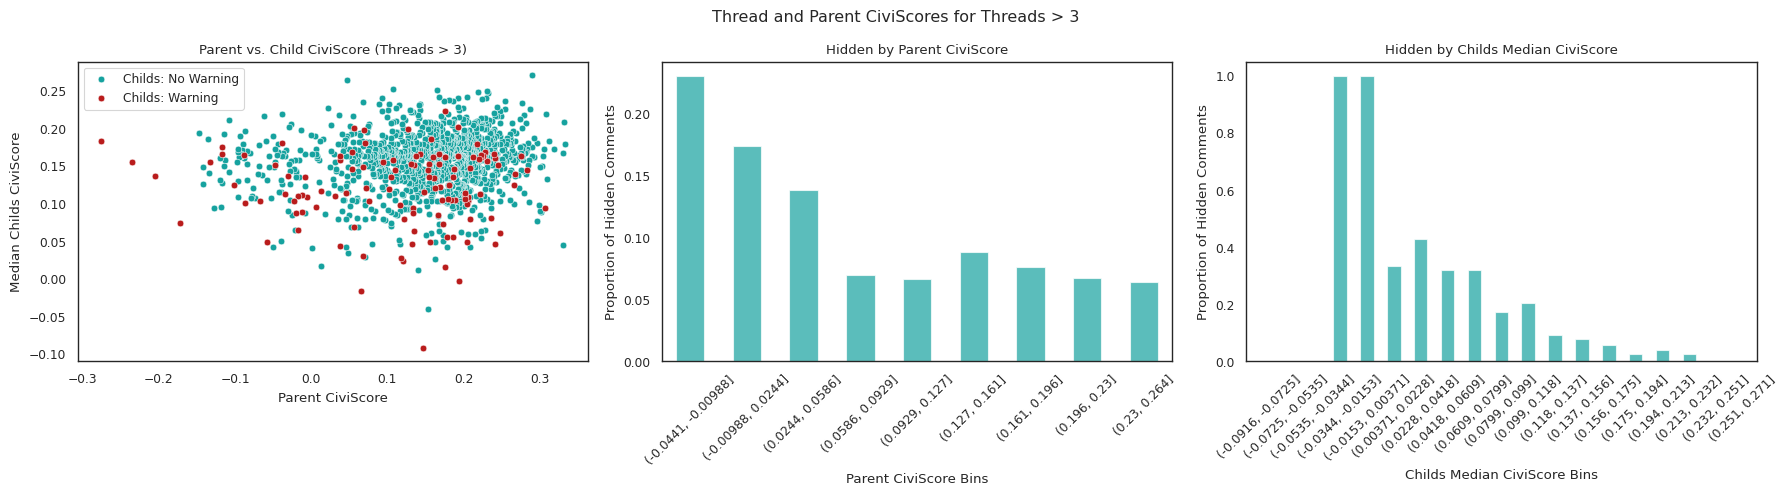

In [67]:
from scipy.stats.mstats import winsorize

comment_threads_greater_than = 3

outlier_threads_more_than_five = outlier_threads[outlier_threads["childs_count"] > comment_threads_greater_than]

fig = plt.figure(figsize=(18, 5))  # wide figure for 3 subplots
ax1 = fig.add_subplot(1, 3, 1)

sns.scatterplot(
    data=outlier_threads_more_than_five[~outlier_threads_more_than_five["warning"]], 
    x="parent_civiscore",
    y="childs_median_civiscore",
    label="Childs: No Warning",
    ax=ax1
)

sns.scatterplot(
    data=outlier_threads_more_than_five[outlier_threads_more_than_five["warning"]], 
    x="parent_civiscore",
    y="childs_median_civiscore",
    label="Childs: Warning",
    ax=ax1
)

ax1.set_xlabel("Parent CiviScore")
ax1.set_ylabel("Median Childs CiviScore")
ax1.set_title(f"Parent vs. Child CiviScore (Threads > {comment_threads_greater_than})")
ax1.legend(loc="best")

leaves_for_histogram = outlier_threads.copy()
leaves_for_histogram = outlier_threads[outlier_threads["childs_count"] > comment_threads_greater_than].copy()

leaves_for_histogram['hidden'] = leaves_for_histogram['warning'].eq(True).astype(int)  # Convert warnings to binary (1 for hidden, 0 otherwise)
leaves_for_histogram['parent_civiscore'] = winsorize(leaves_for_histogram['parent_civiscore'], limits=[0.05, 0.05])
leaves_for_histogram['childs_civiscore_winsorized'] = winsorize(leaves_for_histogram['childs_median_civiscore'], limits=[0.05, 0.05])

bins_parent = np.linspace(leaves_for_histogram['parent_civiscore'].min(), leaves_for_histogram['parent_civiscore'].max(), 10)
bins_child = np.linspace(leaves_for_histogram['childs_median_civiscore'].min(), leaves_for_histogram['childs_median_civiscore'].max(), 20)

leaves_for_histogram['parent_bin'] = pd.cut(leaves_for_histogram['parent_civiscore'], bins=bins_parent)
parent_hidden_proportion = leaves_for_histogram.groupby('parent_bin', observed=False)['hidden'].mean()

# Group by bins for childs_avg_civiscore
leaves_for_histogram['child_bin'] = pd.cut(leaves_for_histogram['childs_median_civiscore'], bins=bins_child)
child_hidden_proportion = leaves_for_histogram.groupby('child_bin', observed=False)['hidden'].mean()



ax2 = fig.add_subplot(1, 3, 2)
parent_hidden_proportion.plot(kind="bar", alpha=0.7, ax=ax2)
ax2.set_xlabel("Parent CiviScore Bins")
ax2.set_ylabel("Proportion of Hidden Comments")
ax2.set_title("Hidden by Parent CiviScore")
ax2.tick_params(axis="x", rotation=45)


ax3 = fig.add_subplot(1, 3, 3)
child_hidden_proportion.plot(kind="bar", alpha=0.7, ax=ax3)
ax3.set_xlabel("Childs Median CiviScore Bins")
ax3.set_ylabel("Proportion of Hidden Comments")
ax3.set_title("Hidden by Childs Median CiviScore")
ax3.tick_params(axis="x", rotation=45)

plt.suptitle(f"Thread and Parent CiviScores for Threads > {comment_threads_greater_than}")
utils.plot(PRINT_PLOTS, "civiscore_parent_child", plt)

/tmp/ipykernel_828/64581074.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  parent_hidden_proportion = leaves_for_histogram.groupby('parent_bin')['hidden'].mean()
/tmp/ipykernel_828/64581074.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  child_hidden_proportion = leaves_for_histogram.groupby('child_bin')['hidden'].mean()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


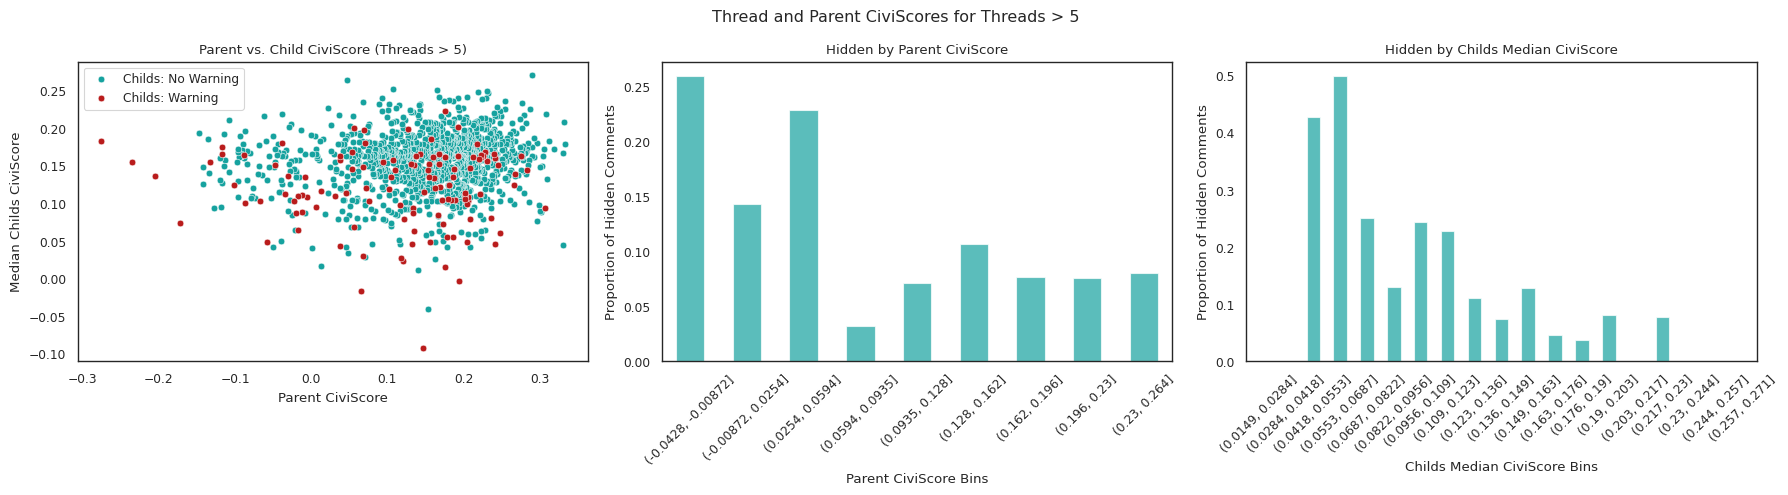

In [68]:
threads_more_than_five = outlier_threads[outlier_threads["childs_count"] > 3]

fig = plt.figure(figsize=(18, 5))  # wide figure for 3 subplots
ax1 = fig.add_subplot(1, 3, 1)

sns.scatterplot(
    data=threads_more_than_five[~threads_more_than_five["warning"]], 
    x="parent_civiscore",
    y="childs_median_civiscore",
    label="Childs: No Warning",
    ax=ax1
)

sns.scatterplot(
    data=threads_more_than_five[threads_more_than_five["warning"]], 
    x="parent_civiscore",
    y="childs_median_civiscore",
    label="Childs: Warning",
    ax=ax1
)

ax1.set_xlabel("Parent CiviScore")
ax1.set_ylabel("Median Childs CiviScore")
ax1.set_title("Parent vs. Child CiviScore (Threads > 5)")
ax1.legend(loc="best")

leaves_for_histogram = outlier_threads[outlier_threads["childs_count"] > 5].copy()

leaves_for_histogram['hidden'] = leaves_for_histogram['warning'].eq(True).astype(int)  # Convert warnings to binary (1 for hidden, 0 otherwise)
leaves_for_histogram['parent_civiscore'] = winsorize(leaves_for_histogram['parent_civiscore'], limits=[0.05, 0.05])
leaves_for_histogram['childs_civiscore_winsorized'] = winsorize(leaves_for_histogram['childs_median_civiscore'], limits=[0.05, 0.05])

bins_parent = np.linspace(leaves_for_histogram['parent_civiscore'].min(), leaves_for_histogram['parent_civiscore'].max(), 10)
bins_child = np.linspace(leaves_for_histogram['childs_median_civiscore'].min(), leaves_for_histogram['childs_median_civiscore'].max(), 20)

leaves_for_histogram['parent_bin'] = pd.cut(leaves_for_histogram['parent_civiscore'], bins=bins_parent)
parent_hidden_proportion = leaves_for_histogram.groupby('parent_bin')['hidden'].mean()

# Group by bins for childs_avg_civiscore
leaves_for_histogram['child_bin'] = pd.cut(leaves_for_histogram['childs_median_civiscore'], bins=bins_child)
child_hidden_proportion = leaves_for_histogram.groupby('child_bin')['hidden'].mean()



ax2 = fig.add_subplot(1, 3, 2)
parent_hidden_proportion.plot(kind="bar", alpha=0.7, ax=ax2)
ax2.set_xlabel("Parent CiviScore Bins")
ax2.set_ylabel("Proportion of Hidden Comments")
ax2.set_title("Hidden by Parent CiviScore")
ax2.tick_params(axis="x", rotation=45)


ax3 = fig.add_subplot(1, 3, 3)
child_hidden_proportion.plot(kind="bar", alpha=0.7, ax=ax3)
ax3.set_xlabel("Childs Median CiviScore Bins")
ax3.set_ylabel("Proportion of Hidden Comments")
ax3.set_title("Hidden by Childs Median CiviScore")
ax3.tick_params(axis="x", rotation=45)

plt.suptitle("Thread and Parent CiviScores for Threads > 5")
utils.plot(PRINT_PLOTS, "outlier_civiscore_parent_child", plt)

10723
NegVotesPercentage_Category
Low (<25%)         0.163401
Medium (25-50%)    0.154489
Medium (50-75%)    0.141982
High (>75%)        0.159697
Name: CiviScore, dtype: float64


/tmp/ipykernel_828/3543488495.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_civiscore = high_engagement_posts.groupby("NegVotesPercentage_Category")["CiviScore"].median()


Text(0.5, 1.0, 'Negative Votes Percentage to CiviScore for comments with more than 10 votes')

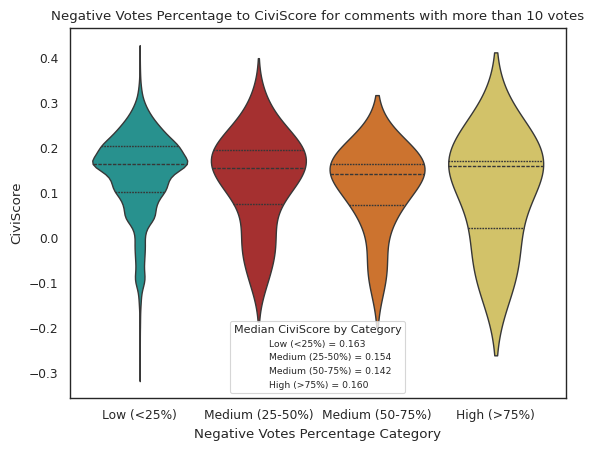

In [69]:
#plot the percentage of negative votes to the civiscore
high_engagement_posts = most_commented_on_scores[(most_commented_on_scores["Votes_Neg"] + most_commented_on_scores["Votes_Pos"]) > 2].copy()
print(len(high_engagement_posts))
high_engagement_posts["NegVotesPercentage"] = (high_engagement_posts["Votes_Neg"] / (high_engagement_posts["Votes_Neg"] + high_engagement_posts["Votes_Pos"])) * 100
high_engagement_posts["NegVotesPercentage_Category"] = pd.cut(
    high_engagement_posts["NegVotesPercentage"],
    bins=[-1, 25, 50, 75,100],  # Custom bins
    labels=["Low (<25%)", "Medium (25-50%)", "Medium (50-75%)", "High (>75%)"]
)
#calculate the median civiscore for each category
median_civiscore = high_engagement_posts.groupby("NegVotesPercentage_Category")["CiviScore"].median()
print(median_civiscore)

ax = sns.violinplot(data=high_engagement_posts, x="NegVotesPercentage_Category", y="CiviScore", hue="NegVotesPercentage_Category", palette=custom_palette[:4], inner="quart")
for category in median_civiscore.index:
    label = f"{category} = {median_civiscore[category]:.3f}"
    ax.plot([], [], ' ', label=label)
ax.legend(title="Median CiviScore by Category", fontsize="x-small", title_fontsize='small',)
ax.set_xlabel("Negative Votes Percentage Category")
ax.set_title("Negative Votes Percentage to CiviScore for comments with more than 10 votes")
#utils.plot(PRINT_PLOTS, "negative_votes_to_civiscore", plt)